# Novel Inertia Based Human Pose Estimation Using CNN

In [25]:
#setup
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io as sio
from utils import *

#need to have these two lines to work on my ancient 1060 3gb
#  https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2
%autosave 180

Autosaving every 180 seconds


In [26]:
#Import data from MatLab SimScape Multibody Simulator

#data comes from two files
#1) n trajectories in xyz space, each length m
# traj = np.loadtxt(open("C:/Users/Derm/Desktop/traj_with_angs_1M.txt", "rb"), delimiter=",")
traj = np.loadtxt(open("simulation/data/traj_9DOF_100k.txt", "rb"), delimiter=",")

trajPts = np.shape(traj)[0] #points per trajectory
# numTraj = np.shape(traj)[1]//3 #number of total trajectories
numTraj = np.shape(traj)[1]//6 #number of total trajectories


#traj needs to be reshaped to a 3d numpy array
#as is traj[n] shows [x,y,z,x,y,z...]


#2) 7 joint angles at the end of the sequence
# jointPos = np.loadtxt(open("C:/Users/Derm/Desktop/jointPos_with_angs_1M.txt", "rb"), delimiter=",")
jointPos = np.loadtxt(open("simulation/data/jointPos_9DOF_100k.txt", "rb"), delimiter=",")

# print(traj[-1])
# print(jointPos[0])



In [27]:
#find and fix errors in data (small number of trials had huge joint angles)
err = np.argwhere(np.abs(jointPos) > 200)
print(err)

for i in err[:,0]:
    print(jointPos[i])
    jointPos[i] = jointPos[int(np.floor(np.random.rand()*np.shape(jointPos)[0]))]

# print(jointPos[17336])

[]


In [28]:
#reshape traj data into 3d numpy array
# t = np.zeros([trajPts,3,numTraj]) #net 1
# for j in range(np.shape(traj)[0]):
#     for i in range(np.shape(traj)[1]//3):
#         t[j,:,i] = traj[j,3*i:3*(i+1)]
        
t = np.zeros([trajPts,6,numTraj]) #net 3
for j in range(np.shape(traj)[0]):
    for i in range(np.shape(traj)[1]//6):
        t[j,:,i] = traj[j,6*i:6*(i+1)]

        
# print(t[:,:,0]) #same as in MatLab
print(np.shape(t))
#swap axis so batch size is first axis (for TF)
t = np.swapaxes(t,0,2)
print(np.shape(t)) #[numTraj, xyz, trajPts]
#swap axis again so that conv1D moves on time and not xyz
t = np.swapaxes(t,1,2)
print(np.shape(t))

(10, 6, 100000)
(100000, 6, 10)
(100000, 10, 6)


In [29]:
# from network import Net1 #optim for 1M linear dataset (not ideal because used inconsistant timesteps in solver)
# from network import Net2 #optim for 100k time varying
# from network import Net3 #optim for data with position and rotation
from network import Net4 #for 9DOF model

np.random.seed(1337)

#convert data from numpy to tensors
x_train = tf.convert_to_tensor(t,np.float32)
y_train = tf.convert_to_tensor(jointPos,np.float32)

# print(tf.shape(x_train))
# print(x_train[0,:,1])

In [6]:
# model = Net1()
# model = Net3()
model = Net4()

runLen = 200    

def scheduler(epoch, lr):
#     part1 = 2*runLen//3
#     part2 = 5*runLen//6 #net1

    part1 = runLen//3
    part2 = 2*runLen//3 #net2

    if epoch < part1:
        lr = 0.01
        return lr
    if epoch >= part1 and epoch < part2:
        lr = 0.001
        return lr
    if epoch >= part2:
        lr = 0.0001
        return lr
    
#     if epoch < part1:
#         lr = 0.001
#         return lr
#     if epoch >= part1 and epoch < part2:
#         lr = 0.0001
#         return lr
#     if epoch >= part2:
#         lr = 0.00001
#         return lr

#model1
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanSquaredError()],)

#model 3 - test with absolute loss?
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(lr=0.001, clipvalue = 0.001),
# #     optimizer = tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, clipvalue=1.0),
#     loss=tf.keras.losses.MeanSquaredError(),
#     metrics=[tf.keras.metrics.MeanSquaredError()],)


summary = model.summary()
print(summary)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

#for 1M linear dataset
# trace = model.fit(x=x_train, y=y_train, batch_size=128, epochs=runLen, verbose=1, 
#                   validation_split=0.1, callbacks = [callback], shuffle=True) 
#New Changes- added 512 conv layer to network #Increases performance drastically (reaches val error of 89.0 in <30 epoch) 
#             adding another layer of 1024 (reaches val error of ~81.5 in <30 epoch)

# for 1M dataset with endpoint angles
# trace = model.fit(x=x_train, y=y_train, batch_size=128, epochs=runLen, verbose=1, 
#                   validation_split=0.1, callbacks = [callback], shuffle=True)
#new changes: added 512 layers back in


# for 10k 9DOF dataset with endpoint angles
trace = model.fit(x=x_train, y=y_train, batch_size=32, epochs=runLen, verbose=1, 
                  validation_split=0.1, callbacks = [callback], shuffle=True)
#new changes: added 512 layers back in

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 6)]      0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 10, 6)        24          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 8, 16)        304         batch_normalization[0][0]        
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 8, 16)        784         conv1d[0][0]                     
_______________________________________________________________________________________

2813/2813 [==============================] - 30s 11ms/step - loss: 553.8610 - mean_squared_error: 553.8610 - val_loss: 418.8369 - val_mean_squared_error: 418.8369
Epoch 2/200
2813/2813 [==============================] - 30s 11ms/step - loss: 422.9314 - mean_squared_error: 422.9314 - val_loss: 413.9671 - val_mean_squared_error: 413.9671
Epoch 3/200
2813/2813 [==============================] - 30s 11ms/step - loss: 392.9374 - mean_squared_error: 392.9374 - val_loss: 383.3968 - val_mean_squared_error: 383.3968
Epoch 4/200
2813/2813 [==============================] - 30s 11ms/step - loss: 362.9102 - mean_squared_error: 362.9102 - val_loss: 325.4873 - val_mean_squared_error: 325.4873
Epoch 5/200
2813/2813 [==============================] - 30s 11ms/step - loss: 338.9238 - mean_squared_error: 338.9238 - val_loss: 331.2856 - val_mean_squared_error: 331.2856
Epoch 6/200
2813/2813 [==============================] - 30s 11ms/step - loss: 323.2931 - mean_squared_error: 323.2931 - val_loss: 309.53

Epoch 48/200
2813/2813 [==============================] - 29s 10ms/step - loss: 197.7206 - mean_squared_error: 197.7206 - val_loss: 203.5168 - val_mean_squared_error: 203.5168
Epoch 49/200
2813/2813 [==============================] - 29s 10ms/step - loss: 195.2972 - mean_squared_error: 195.2972 - val_loss: 207.4172 - val_mean_squared_error: 207.4172
Epoch 50/200
2813/2813 [==============================] - 29s 10ms/step - loss: 194.6648 - mean_squared_error: 194.6648 - val_loss: 223.1331 - val_mean_squared_error: 223.1331
Epoch 51/200
2813/2813 [==============================] - 30s 11ms/step - loss: 194.5311 - mean_squared_error: 194.5311 - val_loss: 274.9151 - val_mean_squared_error: 274.9151
Epoch 52/200
2813/2813 [==============================] - 29s 10ms/step - loss: 192.6626 - mean_squared_error: 192.6626 - val_loss: 197.5536 - val_mean_squared_error: 197.5536
Epoch 53/200
2813/2813 [==============================] - 29s 10ms/step - loss: 192.3960 - mean_squared_error: 192.3960 

2813/2813 [==============================] - 30s 11ms/step - loss: 151.6128 - mean_squared_error: 151.6128 - val_loss: 158.3140 - val_mean_squared_error: 158.3140
Epoch 141/200
2813/2813 [==============================] - 30s 11ms/step - loss: 151.4873 - mean_squared_error: 151.4873 - val_loss: 159.2678 - val_mean_squared_error: 159.2678
Epoch 142/200
2813/2813 [==============================] - 30s 11ms/step - loss: 151.2336 - mean_squared_error: 151.2336 - val_loss: 159.8921 - val_mean_squared_error: 159.8921
Epoch 143/200
2813/2813 [==============================] - 29s 10ms/step - loss: 151.0671 - mean_squared_error: 151.0671 - val_loss: 159.2677 - val_mean_squared_error: 159.2677
Epoch 144/200
2813/2813 [==============================] - 29s 10ms/step - loss: 151.5300 - mean_squared_error: 151.5300 - val_loss: 161.4069 - val_mean_squared_error: 161.4069
Epoch 145/200
2813/2813 [==============================] - 30s 11ms/step - loss: 151.0539 - mean_squared_error: 151.0539 - val_lo

(10.0, 1000.0)

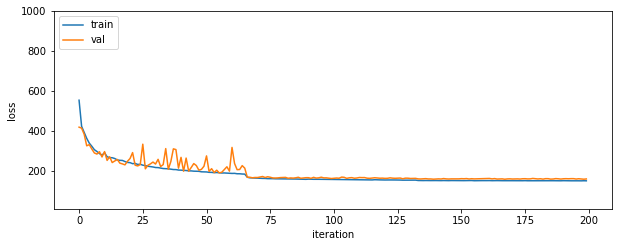

In [7]:
plt.subplot(2, 1, 1)
plt.plot(trace.history['loss'], '-')
plt.plot(trace.history['val_loss'], '-')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.ylim(10,1000)

In [39]:
#test model- IMPORTANT TO USE NEVER BEFORE SEEN DATA

#from train data (not ideal to use for testing)
# prediction = model.predict(x_train[-1000:-1])
# actual = y_train[-1000:-1]

#x_data------------------
# just cart
# trajTest = np.loadtxt(open("simulation/data/traj_2sec.txt", "rb"), delimiter=",")
# trajPtsTest = np.shape(trajTest)[0] #points per test trajectory
# numTrajTest = np.shape(trajTest)[1]//3 #number of test trajectories
# tTest = np.zeros([trajPtsTest,3,numTrajTest])
# for j in range(np.shape(trajTest)[0]):
#     for i in range(np.shape(trajTest)[1]//3):
#         tTest[j,:,i] = trajTest[j,3*i:3*(i+1)]

#cat + angs
trajTest = np.loadtxt(open("simulation/data/traj_9DOF_1k.txt", "rb"), delimiter=",")
trajPtsTest = np.shape(trajTest)[0] #points per test trajectory
numTrajTest = np.shape(trajTest)[1]//6 #number of test trajectories
tTest = np.zeros([trajPtsTest,6,numTrajTest])
for j in range(np.shape(trajTest)[0]):
    for i in range(np.shape(trajTest)[1]//6):
        tTest[j,:,i] = trajTest[j,6*i:6*(i+1)]


        
#swap axis so batch size is first axis (for TF)
tTest = np.swapaxes(tTest,0,2)
#swap axis again so that conv1D moves on time and not xyz
tTest = np.swapaxes(tTest,1,2)
x_test = tf.convert_to_tensor(tTest,np.float32)

#y_data-------------------
# jointPosTest = np.loadtxt(open("simulation/data/jointPos_2sec.txt", "rb"), delimiter=",")
jointPosTest = np.loadtxt(open("simulation/data/jointPos_9DOF_1k.txt", "rb"), delimiter=",")
y_test = tf.convert_to_tensor(jointPosTest,np.float32)

prediction = model.predict(x_test)
error = (y_test - prediction)
# print(np.floor(error))

#average error for estimates for each joint
avg = np.average(abs(error),axis=0)
print("average error = ", avg)

#range for each joint:
ranges = [50, 60, 67.5, 110, 120, 360, 130, 180, 110]
rel_error = avg/ranges
print("error as frac of joint range = ", np.floor(rel_error*1000)/1000) #1 is full range of joint
print("total error = ",sum(rel_error))

#current best for network 1 is: 
#                 0.438 @ [0.09  0.082 0.034 0.086 0.061 0.024 0.058]
#                 val_error: 81.84

#current best for network 3 is: 
#                 0.289 @ [0.068 0.076 0.031 0.046 0.025 0.012 0.029]
#                 val_error: 26.61 
#                 (using 100k dataset)

print("prediction: ",prediction[-11])
print("actual: ", y_test[-11])

average error =  [ 5.0201883  4.973221   2.557517   7.762881   4.953605   8.103199
  5.4501514  4.650566  24.203278 ]
error as frac of joint range =  [0.1   0.082 0.037 0.07  0.041 0.022 0.041 0.025 0.22 ]
total error =  0.6433310112641963
prediction:  [ 1.6663778e-01  6.0017619e-02  4.2232513e-02 -5.5174324e+01
  5.8369389e+00  4.3476067e+01 -1.2273930e+02 -2.7788340e+01
  2.1110658e-01]
actual:  tf.Tensor(
[   3.6747   -3.8233   -2.0731  -62.342     6.7761   43.006  -122.48
  -27.846    41.907 ], shape=(9,), dtype=float32)


In [8]:
# model.save("trajectory_cls.kmod")

# model.save("trajectory_random_forces_cls.kmod")

# model.save("trajectory_with_angs.kmod")

model.save("9DOF_with_angs.kmod")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: 9DOF_with_angs.kmod\assets


In [30]:
#load best scoring model for 1M dataset
# model = tf.keras.models.load_model("trajectory_cls.kmod")

model = tf.keras.models.load_model("9DOF_with_angs.kmod")

In [ ]:
#proof my model is doing better than completely random guessing

np.random.seed(None)

# print(actual)
# print(tf.shape(actual)) #[99 7]
B = tf.random.uniform([1000,7])

# B = tf.ones([99,7])
B = B *tf.constant([25., 30., 33.75, 55. , 60., 180., 65.]) + tf.constant([0., 0., 26.25, -35., 30., 0., -65.])

# print(tf.shape(B))
# print(tf.shape(actual))

fake_error = (y_test - B)
# print(fake_error)

fake_avg = tf.math.reduce_mean(tf.math.abs(fake_error), axis=0)
print(fake_avg)

rel_fake_error = fake_avg/ranges

print("error as frac of joint range: ",rel_fake_error)
print("total error: ", sum(rel_fake_error))

#NOTE: these are not all the same becuase the starting ranges for joint positions do NOT fall in the middle of all
#      possible positions for each joint

In [6]:
from scipy.spatial.transform import Rotation as R
r = R.from_euler('zyx', [
[90, 0, 0],
[0, 45, 0],
[45, 60, 30]], degrees=True)

print(r)
r.as_quat()

v = [1, 2, 3]

r.apply(v)

array([[-2.        ,  1.        ,  3.        ],
       [ 2.82842712,  2.        ,  1.41421356],
       [ 2.24452282,  0.78093109,  2.89002836]])

In [18]:
r1 = R.from_euler('z', 90, degrees=True)
r2 = R.from_euler('x', 90, degrees=True)
r3 = r1*r2

v = [1, 2, 3]

rot1 = r1.apply(v)
rot2 = r3.apply(v)
print(rot2)


[3. 1. 2.]
3.0000000000000013
1.0000000000000004
2.000000000000001


In [23]:
a, b, c= r3.apply([1, 2, 3])
print(a,b,c)


3.0000000000000013 1.0000000000000004 2.000000000000001


TypeError: unsupported operand type(s) for -: 'list' and 'list'